In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
import numpy as np
import pprint

# Qiskit imports
# from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.result import marginal_counts

# Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# QiskitRuntimeService.save_account(channel="ibm_quantum", token="DIN NYCKEL HÄR",overwrite = True)
service = QiskitRuntimeService()



In [2]:
num_qubits = 5
# backend = service.least_busy(operational=True, simulator=False, min_num_qubits=num_qubits)
backend_name = "ibm_brussels"
backend = service.backend(backend_name)
backend

<IBMBackend('ibm_brussels')>

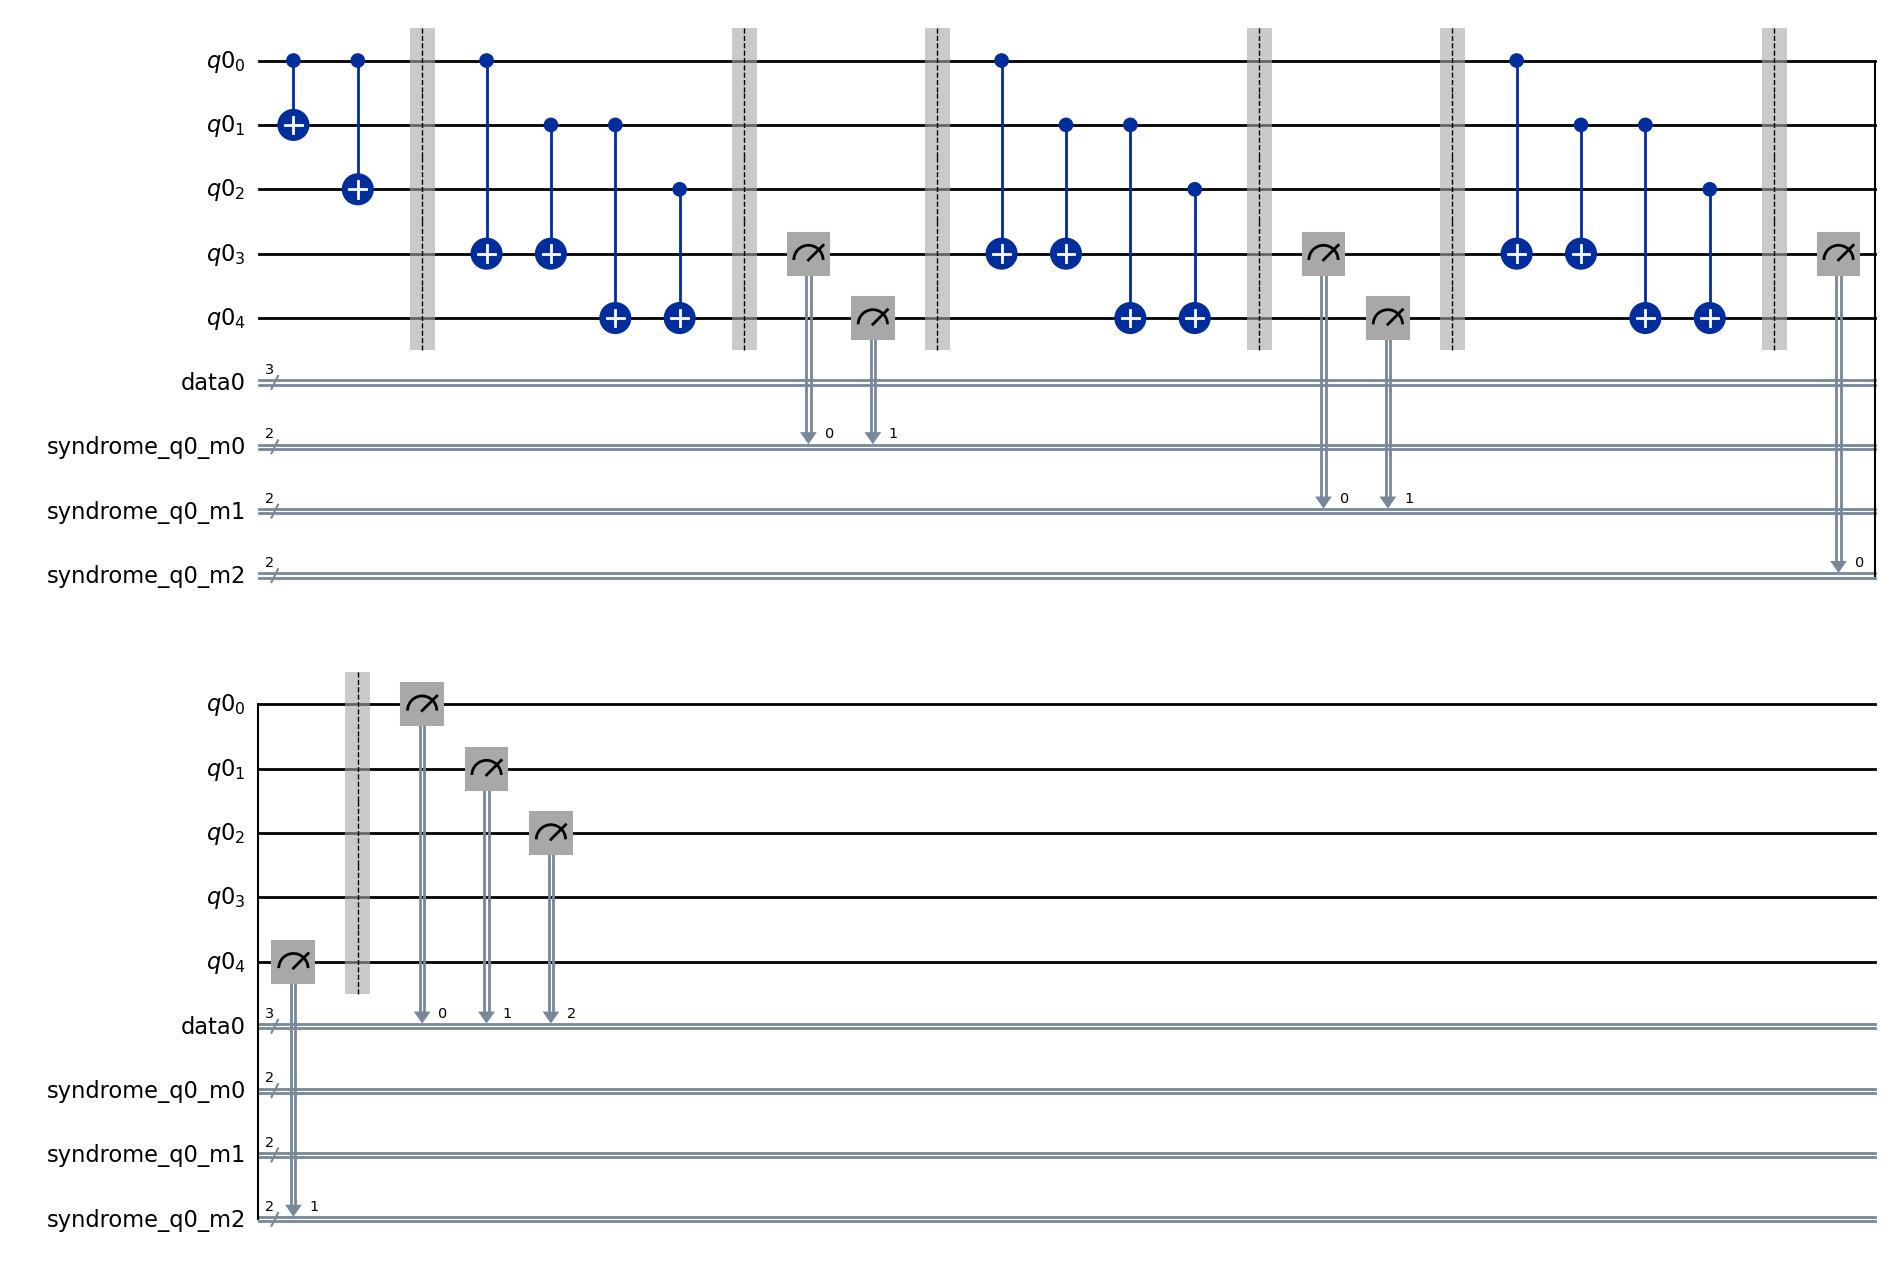

In [3]:


def gen_circuit(k=1, d=3, n_measure = 1):

    # qubits ordered by logical qubit
    qreg_q = [QuantumRegister(2*d-1, f"q{i}") for i in range(k)]

    # Data register ordered by logical qubit
    creg_data = [ClassicalRegister(d, f"data{i}") for i in range(k)]

    # Syndrome register ordered by logical qubit with capacity for multiple measurements
    creg_syndromes = sum([[ClassicalRegister((d-1), f"syndrome_q{i}_m{m}") for m in range(n_measure)] for i in range(k)],[])

    # print(creg_syndromes)
    # print(creg_data)

    circuit = QuantumCircuit(*qreg_q, *creg_data, *creg_syndromes)


    for i in range(k):

        # Entangle redundancy qubits
        for j in range(1,d):
            circuit.cx(qreg_q[i][0], qreg_q[i][j])

        # circuit.barrier(qreg_q[i][0], qreg_q[i][1], qreg_q[i][2], qreg_q[i][3], qreg_q[i][4])
        circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

        for m in range(n_measure):
            # Stabilizer computation
            for j in range(d-1):
                circuit.cx(qreg_q[i][j], qreg_q[i][d+j])
                circuit.cx(qreg_q[i][j+1], qreg_q[i][d+j])

            # circuit.barrier(qreg_q[i][0], qreg_q[i][1], qreg_q[i][2], qreg_q[i][3], qreg_q[i][4])
            circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

            # Measure syndrome
            for j in range(d-1):
                circuit.measure(qreg_q[i][j+d], creg_syndromes[i*n_measure+m][j])

        
            circuit.barrier([qreg_q[i][j] for j in range(2*d-1)])

        for j in range(d):
            circuit.measure(qreg_q[i][j], creg_data[i][j])
        # circuit.measure(qreg_q[1], creg_data[1])
        # circuit.measure(qreg_q[2], creg_data[2])

    return circuit



logic_qubits = 1
qubits_per_logical = 3
number_of_measurements = 3


circuit = gen_circuit(logic_qubits,qubits_per_logical,number_of_measurements)

circuit.draw(output="mpl", style='iqp')




In [4]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)

# isa_circuit.draw('mpl', style='iqp', idle_wires=False)

In [5]:
sampler = Sampler(backend)
shots = 10
job = sampler.run([isa_circuit], shots=shots)
result = job.result()[0]

In [6]:

printResult = False


data = []
for i in range(logic_qubits):
    logic = [eval(f"result.data.data{i}.get_bitstrings()")]

    if printResult:
        print("")
        print(f"Logical qubit {i}")

    for m in range(number_of_measurements):
        d = eval(f"result.data.syndrome_q{i}_m{m}.get_bitstrings()")
        logic.append(d)

        if printResult:
            print(f"Measurement {m}")
            print(d)

    data.append(logic)



print("\nData:")
for i, logicQ in enumerate(data):
    print(f"\nLogicq{i}:")
    for d in logicQ:
        print(d)


Data:

Logicq0:
['101', '000', '110', '001', '001', '010', '000', '001', '100', '000']
['00', '00', '11', '00', '00', '00', '00', '00', '00', '00']
['01', '00', '00', '00', '00', '11', '00', '00', '00', '00']
['00', '00', '11', '01', '00', '01', '00', '00', '00', '00']


In [7]:
import repetition_code_data as rcd
import json

settings = ["test", backend_name, qubits_per_logical, shots, number_of_measurements, "0.0"]

data_handler = rcd.repetition_code_data(*settings)


with open(data_handler.run + '_data/Raw_data/result_matrix_'+data_handler.backend_name+'_'+str(data_handler.code_distance)+'_'
    +str(data_handler.shots)+'_'+str(data_handler.time_steps)+'_'+data_handler.version+'.json', 'w') as outfile:
    outfile.write(json.dumps(data[0]))

data_handler.format()
data_handler.error_analyzer_q()
data_handler.error_analyzer_t()

array([[ 0.        ,  0.140625  ,  0.16666667,  0.21875   ,  0.16666667,
         0.21875   ,  0.375     , -0.09375   ],
       [ 0.140625  ,  0.        ,  0.16666667,  0.21875   ,  0.16666667,
         0.21875   ,  0.375     , -0.09375   ],
       [ 0.16666667,  0.16666667,  0.        ,  0.58333333,  0.44444444,
         0.16666667,  1.        , -0.25      ],
       [ 0.21875   ,  0.21875   ,  0.58333333,  0.        ,  0.58333333,
         0.6875    ,  2.25      ,  0.0625    ],
       [ 0.16666667,  0.16666667,  0.44444444,  0.58333333,  0.        ,
         0.16666667,  1.        , -0.25      ],
       [ 0.21875   ,  0.21875   ,  0.16666667,  0.6875    ,  0.16666667,
         0.        ,  1.        ,  0.0625    ],
       [ 0.375     ,  0.375     ,  1.        ,  2.25      ,  1.        ,
         1.        ,  0.        , -0.25      ],
       [-0.09375   , -0.09375   , -0.25      ,  0.0625    , -0.25      ,
         0.0625    , -0.25      ,  0.        ]])

In [9]:
import repetition_code_MWPM as rcdmwpm

mwpm = rcdmwpm.repetition_code_MWPM(*settings)

mwpm.MWPM()

0
[[ 1.61180957e+01  1.96165851e+00  1.79175947e+00  1.51982575e+00
   1.79175947e+00  1.51982575e+00  9.80829253e-01  1.61180957e+01]
 [ 1.96165851e+00  1.61180957e+01  1.79175947e+00  1.51982575e+00
   1.79175947e+00  1.51982575e+00  9.80829253e-01  1.61180957e+01]
 [ 1.79175947e+00  1.79175947e+00  1.61180957e+01  5.38996501e-01
   8.10930216e-01  1.79175947e+00 -2.22044605e-16  1.61180957e+01]
 [ 1.51982575e+00  1.51982575e+00  5.38996501e-01  1.61180957e+01
   5.38996501e-01  3.74693449e-01 -8.10930216e-01  2.77258872e+00]
 [ 1.79175947e+00  1.79175947e+00  8.10930216e-01  5.38996501e-01
   1.61180957e+01  1.79175947e+00 -2.22044605e-16  1.61180957e+01]
 [ 1.51982575e+00  1.51982575e+00  1.79175947e+00  3.74693449e-01
   1.79175947e+00  1.61180957e+01 -4.44089210e-16  2.77258872e+00]
 [ 9.80829253e-01  9.80829253e-01 -2.22044605e-16 -8.10930216e-01
  -2.22044605e-16 -4.44089210e-16  1.61180957e+01  1.61180957e+01]
 [ 1.61180957e+01  1.61180957e+01  1.61180957e+01  2.77258872e+00
 

0.09999999999999998